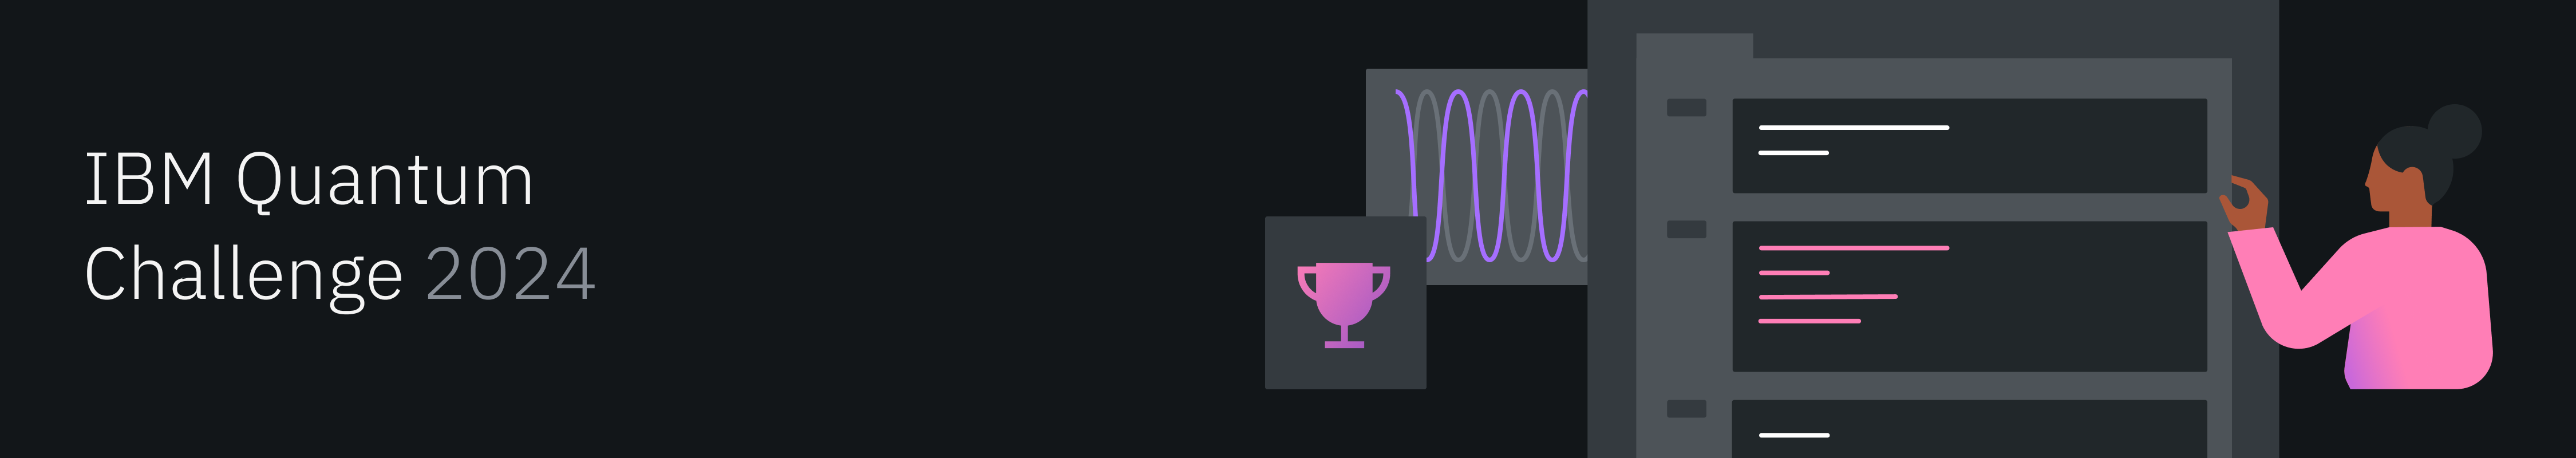

# Lab 1: Qiskit 1.0 へようこそ

## セットアップ

In [ ]:
### Install Qiskit, if needed

!pip install qiskit[visualization]==1.0.2
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install pylatexenc
!pip install prototype-zne

In [1]:
# Load your API token in .env

%load_ext dotenv
%dotenv

In [2]:
# imports
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

## はじめに

Lab 1 へようこそ！この最初の Lab は、 Qiskit 1.0の新機能の一部を紹介するためのものです。後の Challenge ではこれらの機能をさらに発展させ、より複雑な Qiskit の新機能を紹介します。

この Lab では、Qiskitを使用して量子状態を設定する方法と、VQEを使用して最適化アルゴリズムを実装する方法を学びます。この2つのタスクは2つのセクションに分かれています：

1) Qiskitの状態、新しいものと古いもの 
2) Qiskit 1.0 を使った VQE

それでは始めましょう！

## Part I: Qiskitの状態、新しいものと古いもの 

### Exercise 1: 一重項のベル状態の回路を作って描く

````{admonition} Exercise
ベル回路は、ベル状態、すなわち EPR ペアを生成する特定の回路であり、エンタングルされ正規化された基底ベクトルの一種を作る回路です。 言い換えれば、量子ビットの重要な特性であるエンタングルメント状態を生成するための回路です。

4 つの異なるベル状態が存在します。 それぞれについて、 [量子情報の基礎のページ](https://learning.quantum.ibm.com/course/basics-of-quantum-information/multiple-systems#bell-states) で学ぶことができます。

**あなたのタスク：** $| \psi ^- \rangle$ のベル状態を生成する回路を構築してください。

```python
"""
 Build a circuit to form a psi-minus Bell state
 Apply gates to the provided QuantumCircuit, qc
"""

qc = QuantumCircuit(2)

##### Write your code below here #####



##### Don't change any code past this line #####
qc.measure_all()
qc.draw('mpl')
```
````

```{hint}
$\ket \psi ^- = \frac{1}{\sqrt{2}} (\ket{01} - \ket{10})$ のベル状態には、Zゲート1つとXゲート1つが使われ、どちらもCNOTの後に必要です。
```

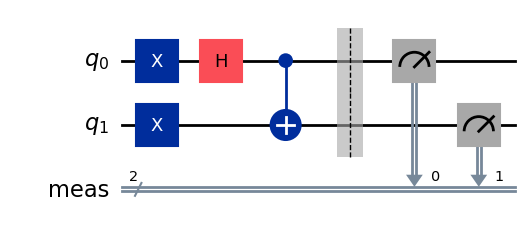

In [3]:
# Build a circuit to form a psi-minus Bell state
# Apply gates to the provided QuantumCircuit, qc

qc = QuantumCircuit(2)

### Write your code below here ###
qc.x(0)
qc.x(1)
qc.h(0)
qc.cx(0,1)
### Don't change any code past this line ###
qc.measure_all()
qc.draw('mpl')

この回路が作り出すエンタングルされた状態を観察するために、回路を何回も走らせ、最終的な量子ビットの測定値の統計を取ります。これが次の Exercise のゴールです。

### Exercise 2: Sampler Primitives を使う
````{admonition} Exercise
[Qiskit Sampler](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler) primitive ([Primitives の詳細はこちら](https://docs.quantum.ibm.com/run/primitives-get-started))は、指定された出力タイプに従ってサンプリングされた結果を返します。量子回路を実行し、量子状態の確率分布を提供することで、量子状態を効率的にサンプリングすることができます。

**あなたのタスク：** Qiskit `StatevectorSampler` を使用して、回路から結果のカウントを取得してください。

```python
qc.measure_all()

##### Write your code below here #####


sampler = #Add your code here
pub = #Add your code here
job_sampler = #Add your code here


##### Don't change any code past this line #####

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)
```
````

In [4]:
qc.measure_all()

### Write your code below here ###


sampler = StatevectorSampler() #Add your code here
pub = [qc] #Add your code here
job_sampler = sampler.run(pub) #Add your code here


### Don't change any code past this line ###

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'01': 499, '10': 525}


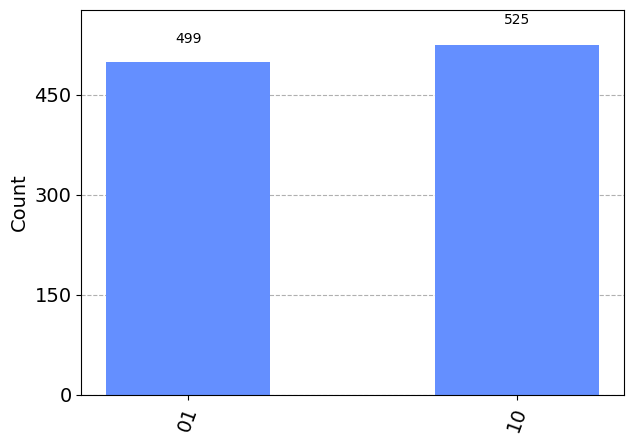

In [5]:
plot_histogram(counts_sampler)

ヒストグラムは、私たちの量子ビットが `01` か `10` の状態で見つかる確率がほぼ等しいことを示していて、エンタングルメントが期待通りに行われたことを示唆しています。

### Exercise 3: W状態回路を描く

````{admonition} Exercise
次に、少し複雑な回路を開発します。ベル状態回路がベル状態を生成するのと同様に、W状態回路は W状態を生成します。ベル状態は2つの量子ビットをエンタングルしますが、W状態は3つの量子ビットをエンタングルします。W状態を作るには、6つの簡単なステップに従います：

1) 3量子ビット回路を初期化します。
2) 量子ビットのRy回転を行います。この演算は与えられています。
3) 制御アダマールゲートをqubit 0を制御ビットとしてqubit 1に実行します。
4) qubit 1を制御ビット、qubit 2を目標ビットとして、CNOTゲートを実行します。
5) qubit 0を制御ビット、qubit 1を目標ビットとして、CNOTゲートを実行します。
6) qubit 0にXゲートを追加します。

**あなたのタスク：** W-状態回路を構築する手順に従ってください。

```python
##### Step 1
qc = #your_code_here

##### Step 2 (provided)
qc.ry(1.91063324, 0)

##### Add steps 3-6 below




##### Don't change any code past this line #####
qc.measure_all()
qc.draw('mpl')
```
````

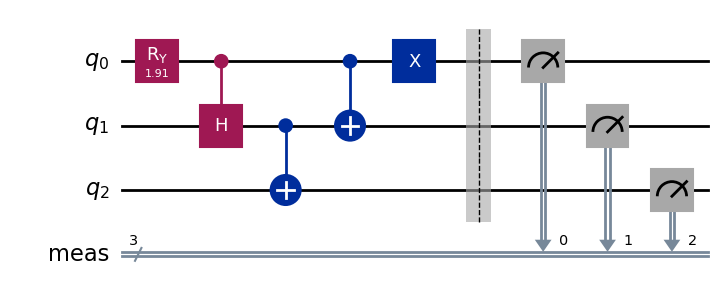

In [6]:
# Step 1
qc = QuantumCircuit(3) #your_code_here

# Step 2 (provided)
qc.ry(1.91063324, 0)

# Add steps 3-6 below
qc.ch(0, 1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.x(0)

### Don't change any code past this line ###
qc.measure_all()
qc.draw('mpl')

もう一度、結果を視覚化してみましょう：

In [7]:
sampler = StatevectorSampler()
pub = (qc)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'010': 3320, '100': 3404, '001': 3276}


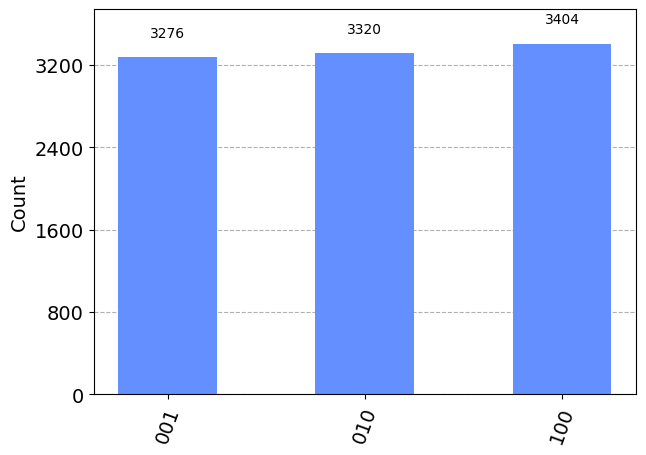

In [8]:
plot_histogram(counts_sampler)

合計カウントが 3 つの状態に同じように分布していることがわかり、W-状態であることが示されました。

基本的な回路を理解したところで、Qiskit 1.0を使ってより複雑なコードの導入と開発を始めます。

## Part II: Qiskit 1.0 での VQE

この Challenge の中核は Qiskit Runtime と 変分量子固有値ソルバー (Variational Quantum Eigensolver, VQE) を活用します。量子ビットの組み合わせの期待値を計算するために Qiskit Runtime Estimator を使用し、 VQE アルゴリズムの実行を容易にするために Qiskit Runtime Sessions を使用します。この Challenge は、実験物理学者で IBM の量子研究者である Nick Bronn が [Coding with Qiskit Runtime video series](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqAC8DnVoLOzg2bKE4C7ARM) 、特に [Episode 05 Primitives & Sessions](https://youtu.be/yxuH8eb4MS4?si=e3trSORNjooWlQXu) のために作成した例のコードを利用し、最新の Qiskit 1.0 バージョンを使用して実装します。

### パウリ演算子を作る

パウリ演算子は、特定の軸 (x, y, z) に沿ったスピンの測定に対応する量子力学的観測量を表す行列です。作ってみましょう：

In [9]:
pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
print(pauli_op.to_matrix())

[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -3.+0.j]]


さまざまなパウリ演算子を使って、どのような組み合わせが得られるか、自由に実験してみてください！

### VQEアルゴリズムのセットアップと実行

次に、VQEアルゴリズムのセットアップを始めます。変分量子固有値ソルバー (VQE) は、量子と古典のハイブリッド・アルゴリズムであり、与えられた物理系の基底状態を見つけるために、量子と古典のテクニックを利用します。 VQE は量子化学や最適化問題でよく使われており、ノイズの多い近未来デバイスのハイブリッド・アルゴリズムとして有望視されています。

VQE は、「Ansatz(仮説)」と呼ばれるパラメーター化された試行的な解を繰り返し更新するために、古典的な最適化アルゴリズムを用いることが特徴です。その目的は、パウリ項の線形結合として表される与えられたハミルトニアンの基底状態を解くことです。

VQE アルゴリズムを実行するには、3つのステップが必要です：

1) ハミルトニアンと Ansatz(仮説) の設定 (問題の設定)
2) Qiskit Runtime estimator の実装
3) 古典オプティマイザーを追加し、プログラムを実行する

私たちは、これらのステップに従います。


#### Exercise 4: Ansatz となるパラメーター化された回路の作成

````{admonition} Exercise
私たちの最初のタスクは、私たちが比較する問題に対する Ansatz (試行的な解) を設定するこtです。

これには、 Qiskit の TwoLocal circuit を使用します。 TwoLocal circuit は、変分量子アルゴリズムの試行波動関数や機械学習の分類回路を準備するために使用できる、あらかじめ構築された回路です。 TwoLocal circuit は回転層とエンタングルメント層を交互に配置したパラメーター化された回路です。詳細は [Qiskit's documentation](https://docs.quantum.ibm.com/api/qiskit/circuit_library) を参照してください。 

**あなたのタスク：** [Ry](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RYGate) 回転と [Rz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RZGate) 回転を使用した3量子ビットの TwoLocal circuit をセットアップしてください。 entanglement は full に設定し、 entanglement blocks は Cz にします。 `reps=1`、`insert_barriers=True` に設定してください。

```python
num_qubits = #Add your code here
rotation_blocks = #Add your code here
entanglement_blocks = #Add your code here
entanglement = #Add your code here

ansatz = #Add your code here


##### Don't change any code past this line #####
ansatz.decompose().draw('mpl')
```
````

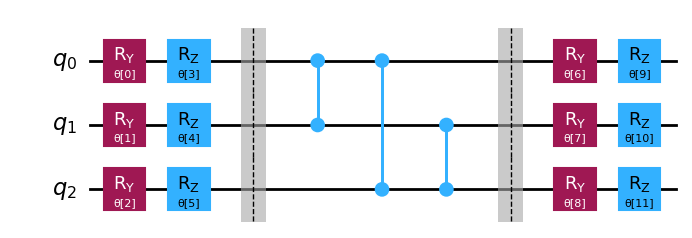

In [10]:
num_qubits = 3 #Add your code here
rotation_blocks = ['ry', 'rz'] #Add your code here
entanglement_blocks = 'cz' #Add your code here
entanglement = 'full' #Add your code here

ansatz = TwoLocal(
    num_qubits,
    rotation_blocks,
    entanglement_blocks,
    entanglement, reps=1,
    insert_barriers=True
)#Add your code here


### Don't change any code past this line ###
ansatz.decompose().draw('mpl')

先ほどの図から、私たちの ansatz 回路はパラメーター θ のベクトルによって定義され、その総数は次式で与えられることがわかります：

In [11]:
num_params = ansatz.num_parameters
num_params

12

#### Exercise 5: ISA 回路へのトランスパイル

````{admonition} Exercise
この例では、 [FakeSherbrooke](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.fake_provider.FakeSherbrooke) を使用します。FakeSherbrooke は偽の（シミュレートされた）127qubitバックエンドであり、 Transpiler やその他のバックエンド向けの機能のテストに便利です。

Preset pass managers は `transpile()` 関数が使用するデフォルトのpass manager です。 `transpile()` は、transpile関数が量子回路を特定のバックエンドで実行するために最適化および変換する際に行うことを反映した、スタンドアロンの PassManager オブジェクトを構築するための便利でシンプルなメソッドを提供します。

**あなたのタスク：** pass manager を定義してください。詳細は [Qiskit documentation](https://docs.quantum.ibm.com/api/qiskit/0.42/qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) を参照してください。

```python
backend_answer = #Add your code
optimization_level_answer = #Add your code
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = # Add your code
```
````

In [12]:
backend_answer = FakeSherbrooke() #Add your code
optimization_level_answer = 2 #Add your code
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz) # Add your code

Qiskit Runtime の最新バージョンでは、バックエンドに提出されるすべての回路は、バックエンドのターゲットの制約に準拠しなければなりません。 このような回路は、[ISA (Instruction Set Architecture)](https://www.ibm.com/quantum/blog/isa-circuits?social_post=sf187802680&sf187802680=1)、つまりデバイスが理解し実行できる命令セットの観点から記述されていると見なされます。 

これらのターゲット制約は、デバイスのネイティブな基本ゲート、量子ビットの接続性、関連する場合はパルスやその他の命令タイミング仕様などの要因によって定義されます。 

ISA 回路を定義するために、私たちは以下を実行します：

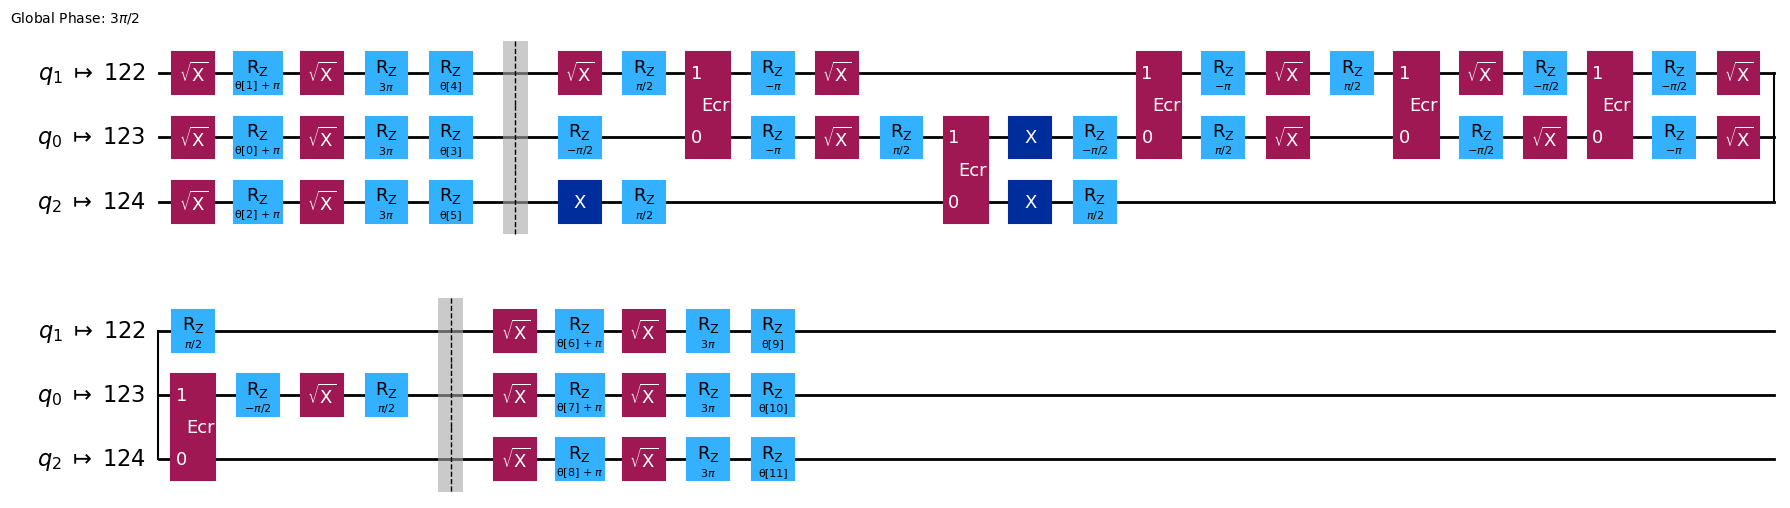

In [13]:
isa_circuit.draw('mpl', idle_wires=False,)

ご覧のように、トランスパイル後の回路には、バックエンドのネイティブな基本ゲートしか含まれていません。 ISA回路の詳細については、こちらをご覧ください：
- [ISA回路とは(和訳版)](https://www.ibm.com/blogs/systems/jp-ja/isa-circuits/)
- [新しいISA回路要件を理解する](https://docs.quantum.ibm.com/announcements/news/2024-05-06-ISA-circuit-requirement#understanding-the-new-isa-circuits-requirement)

次のセルを実行してハミルトニアンを定義し、 Exercise 6に進むことができます。

In [14]:
# Define our Hamiltonian
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)

```{warning}
    
以下の2つの Exercise では、Qiskit 1.0.2 で動かしていることを確認してください！

このバージョンは次のようにしてダウンロードできます: **!pip install qiskit==1.0.2**
```

#### Exercise 6: コスト関数の定義
````{admonition} Exercise
多くの古典的な最適化問題と同様に、VQE問題の解はスカラーのコスト関数の最小化として定式化することができます。 我々のVQEのコスト関数は単純で、エネルギーです！

**あなたのタスク：** Qiskit Runtime Estimator を使用してコスト関数を定義し、与えられたパラメーター化された状態とハミルトニアンに対するエネルギーを求めてください。

```python
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = #Add your code
    result = #Add your code
    energy = #Add your code

    callback_dict["iters"] += #Add your code
    callback_dict["prev_vector"] = #Add your code
    callback_dict["cost_history"].#Add your code


##### Don't change any code past this line #####
    print(energy)
    return energy, result
```
````

In [15]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params]) #Add your code 'pub-like' object e.g. a list of circuits or tuples
    result = estimator.run([pub]).result() #Add your code
    energy = result[0].data.evs[0] #Add your code

    callback_dict["iters"] += 1 #Add your code
    callback_dict["prev_vector"] = params #Add your code
    callback_dict["cost_history"].append(energy) #Add your code


### Don't change any code past this line ###
    print(energy)
    return energy, result

コールバック関数は、ユーザーが反復アルゴリズム (VQE など) のステータスに関する追加情報を取得するための標準的な方法です。 しかし、これ以上のことも可能です。 ここでは、失敗のためにルーチンを再開したり、別の反復番号を返す必要がある場合に備えて、アルゴリズムの各反復における結果ベクトルを保存するために、変更可能なオブジェクト (辞書) を使用します。

In [16]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

### 古典オプティマイザーの使用

ここで、コスト関数を最小化するために、任意の古典オプティマイザーを使用することができます。実際の量子ハードウェアでは、オプティマイザーの選択が重要です。すべてのオプティマイザーがノイズの多いコスト関数のランドスケープを同じように扱えるとは限らないからです。ここでは、 SciPy ルーチンを使用します。

ルーチンを開始するために、パラメーターの初期値としてランダムなセットを指定します：

In [17]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([5.13314893, 6.08368564, 4.78654363, 4.05974472, 4.86944018,
       5.3598984 , 2.21243985, 0.25798934, 5.03440199, 5.63744607,
       0.22972544, 1.37424923])

### Qiskit PrimitivesV2の使用
#### Exercise 7: 初めての`QiskitRuntimeService V2 Primitives` と `local testing mode` と `Sessions`
````{admonition} Exercise
次に、新しい QiskitRuntimeService [V2 primitives](https://docs.quantum.ibm.com/api/migration-guides/v2-primitives)を使ってみましょう： [EstimatorV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) と [SamplerV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2) です。

新しい Estimator インターフェースでは、1つの回路と、その回路に対する複数の観測値やパラメーター値のセットを指定することができ、パラメーター値のセットや観測値に対するスイープを効率的に指定することができます。 以前は、結合するデータのサイズに合わせて、同じ回路を複数回指定する必要がありました。 また、引き続き、optimization_level と resilience_level を簡単なレベル調整として使用することができ、さらに V2 primitives では、個々のエラー緩和/抑制メソッドをオン/オフして、ニーズに合わせてカスタマイズできる柔軟性があります。

Sampler V2 は、量子回路の実行から量子レジスターをサンプリングするというコアタスクに集中するために簡素化されています。 プログラムによって定義されたタイプのサンプルを重みなしで返します。 また、出力データはプログラムで定義された出力レジスター名で区切られます。 この変更により、将来的には古典的な制御フローを持つ回路のサポートが可能になります。

また、Qiskitの1.0 の [local testing mode](https://docs.quantum.ibm.com/verify/local-testing-mode) を使用します。local testing mode (qiskit-ibm-runtime 0.22.0以降で利用可能) は、プログラムを微調整して実際の量子ハードウェアに送信する前に、プログラムの開発やテストに役立ちます。


**あなたのタスク：** local testing mode を使用してプログラムを検証した後、IBM Quantum システムで実行するためにバックエンド名を変更するだけです。

```python
##### Select a Backend
##### Use FakeSherbrooke to simulate with noise that matches closer to the real experiment. This will run slower.
##### Use AerSimulator to simulate without noise to quickly iterate. This will run faster.

backend = FakeSherbrooke()
##### backend = AerSimulator()

##### Don't change any code past this line #####

##### Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method="cobyla",
        options={'maxiter': 30})
```
````

In [18]:
### Select a Backend
## Use FakeSherbrooke to simulate with noise that matches closer to the real experiment. This will run slower.
## Use AerSimulator to simulate without noise to quickly iterate. This will run faster.

backend = FakeSherbrooke()
# backend = AerSimulator()

# ### Don't change any code past this line ###

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(session=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method="cobyla",
        options={'maxiter': 30})

/home/dmurata/workspace/quantum/ibm-quantum-challenge-textbook/.venv/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


0.43115234375
-0.16455078125
-0.2734375
0.1396484375
-0.26806640625
-0.265625
-0.5146484375
-0.8828125
-1.33251953125
-0.80712890625
-1.3095703125
-1.32861328125
-1.37255859375
-1.2568359375
-1.07080078125
-1.01904296875
-1.349609375
-1.20068359375
-1.33447265625
-1.2216796875
-1.28466796875
-1.142578125
-1.3388671875
-1.3447265625
-1.34814453125
-1.3056640625
-1.45751953125
-1.447265625
-1.60986328125
-1.732421875


```{tip}
最適化が見られない場合は、maximiterを変更する
もしCostが最小化されない場合は、 maximeter を上げ (100が適切) 、Ex 7 を再度実行してください。    
```

結果を見てみましょう:

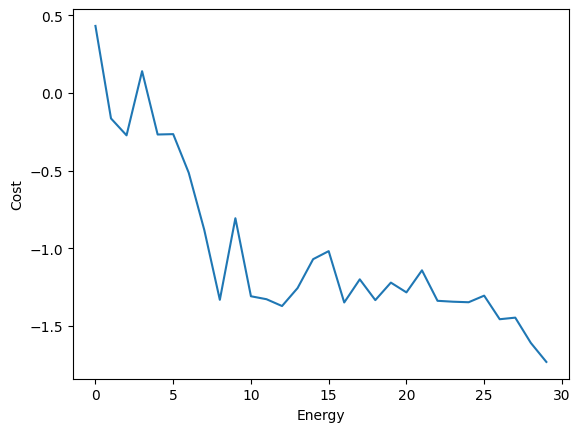

In [19]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
plt.xlabel("Energy")
plt.ylabel("Cost")
plt.draw()

🎉 予想通り、我々の VQE アルゴリズムは、基底状態に到達するまでの反復においてエネルギーを最小化しました。 Qiskit 1.0 の新機能を使った VQE アルゴリズムの実装に成功しました！

このチャレンジを完了していただきありがとうございます。残りのチャレンジも頑張ってください!

## 追加情報

**Created by:** James Weaver, Maria Gragera Garces

**Advised by:** Junye Huang

**Translated by:** Kifumi Numata

Version: 1.1.0